<a href="https://www.kaggle.com/code/yanpapadakis/timeseriesforecasting?scriptVersionId=137080710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Multivariate Time Series Forecasting

Using LSTM Neural Networks in PyTorch and Multiple GPUs

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
if torch.cuda.is_available():
    dev = ["cuda:{}".format(i) for i in range(torch.cuda.device_count())]
else:
    dev = ["cpu"]

# Generate Simulated Data

In [3]:
lookback = 10
mem_length = 6
n = 20000
use_features = [0,1,2]
n_features = len(use_features)
pred_features = [0,2]
n_dim = len(pred_features)
train_split_ratio = 0.70
test_split_ratio  = 0.20
train_size = int(n * train_split_ratio)
test_size  = int(n * test_split_ratio)

In [4]:
np.random.seed(2021)
timeseries = np.random.normal((-0.01,0.0),size=(n,n_features-1)).cumsum(0).astype('float32')
tmp = timeseries.prod(1).reshape(-1,1)
tmp = np.sqrt(tmp - tmp.min())
timeseries = np.hstack((timeseries, tmp - tmp[0]))
mem = np.zeros(n)
mem[0] = 5.0
mem[np.random.choice(n-1, size=n//100)+1] = 5.0
for i in range(n-mem_length):
    mem[i+mem_length] += 0.9 * mem[i]
timeseries[:,0] += mem
ts_length, n_features = timeseries.shape

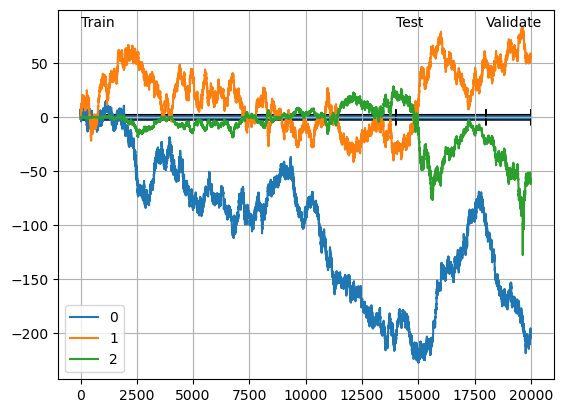

In [5]:
offset = timeseries.max()
plt.plot(timeseries);
plt.arrow(0, 0, train_size, 0, width=5)
plt.annotate("Train", [0,offset])
plt.arrow(train_size, 0, test_size, 0, width=5)
plt.annotate("Test", [train_size,offset])
plt.arrow(train_size+test_size, 0, n - test_size - train_size, 0, width=5)
plt.annotate("Validate", [train_size+test_size,offset])
plt.legend(range(timeseries.shape[1]))
plt.grid();

# Build Time Series Model

Normalize Data

In [6]:
# train-test split for time series
train    = timeseries[:train_size,:]
test     = timeseries[train_size:(train_size+test_size),:]
vld_test = timeseries[(train_size+test_size):,:]

In [7]:
scaler = MinMaxScaler()
scaler.fit(train);
print(1/scaler.scale_)

[232.0916   108.614525  47.38198 ]


In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(lookback,len(dataset)):
        feature = dataset[i-lookback:i]
        target = dataset[i, pred_features]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(np.array(X)).to(dev[0]), torch.FloatTensor(np.array(y)).to(dev[0])

X_train, y_train = create_dataset(scaler.transform(train), lookback=lookback)
X_test,  y_test  = create_dataset(scaler.transform(test), lookback=lookback)
X_vld,   y_vld   = create_dataset(scaler.transform(vld_test), lookback=lookback)

In [9]:
class TSModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=hidden_size, batch_first=True)
        self.lstm = nn.DataParallel(self.lstm)
        self.linear = nn.Linear(hidden_size, n_dim)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.loss_fn = nn.MSELoss()
    def evaluate(self, X, y):
        with torch.no_grad():
            return self.loss_fn(self.__call__(X),y).item()
    def forward(self, x):
        # x dim: batch size X lookback size X n_features
        x, _ = self.lstm(x)
        x = self.dropout(x)
        # x dim: batch size X lookback size X hidden layer size
        x = self.linear(x)
        # x dim: batch size X lookback size X n_dim
        # Dim 0: Obs Index in Batch, Dim 1: Feature, Dim 2: Lookback Index
        x = self.pool(x.permute(0,2,1)) # Pool Lookbacks using 1d Pooling
        # x dim: batch size X n_dim X 1
        x = x.flatten(1) # Drop Last Dimension
        # x dim: batch size X n_dim
        return x

# Fit Model

In [10]:
hidden_size = 500
tsmod = TSModel(hidden_size).cuda()

optimizer = optim.Adam(
    tsmod.parameters(), 
    #lr=5e-4, 
    weight_decay=1e-5
)

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=256)

n_epochs = 301
best_loss = 100.0
model_path = 'best_params.pt'
res_fmt = "Epoch {epoch:3d}:  Train Loss {train_loss:6.4f} / Test Loss {test_loss:6.4f}"
for epoch in range(n_epochs):
    # Training
    tsmod.train()
    for X_batch, y_batch in loader:
        y_pred = tsmod(X_batch)
        loss = tsmod.loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    tsmod.eval()
    test_loss  = np.sqrt(tsmod.evaluate(X_test, y_test))
    train_loss = np.sqrt(loss.item())
    if best_loss > test_loss:
        best_loss = test_loss
        chkpoint = {
            'epoch': epoch,
            'model_state_dict': tsmod.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': test_loss,
            'train_loss': train_loss
        }
        torch.save(chkpoint, model_path)
    if epoch % 10 != 0:
        continue
    print(res_fmt.format(epoch=epoch, train_loss=train_loss, test_loss=test_loss))

Epoch   0:  Train Loss 0.0689 / Test Loss 0.3173
Epoch  10:  Train Loss 0.0229 / Test Loss 0.0819
Epoch  20:  Train Loss 0.0222 / Test Loss 0.0677
Epoch  30:  Train Loss 0.0213 / Test Loss 0.0577
Epoch  40:  Train Loss 0.0173 / Test Loss 0.0483
Epoch  50:  Train Loss 0.0193 / Test Loss 0.0418
Epoch  60:  Train Loss 0.0180 / Test Loss 0.0319
Epoch  70:  Train Loss 0.0170 / Test Loss 0.0320
Epoch  80:  Train Loss 0.0174 / Test Loss 0.0305
Epoch  90:  Train Loss 0.0176 / Test Loss 0.0292
Epoch 100:  Train Loss 0.0177 / Test Loss 0.0291
Epoch 110:  Train Loss 0.0176 / Test Loss 0.0274
Epoch 120:  Train Loss 0.0163 / Test Loss 0.0297
Epoch 130:  Train Loss 0.0158 / Test Loss 0.0277
Epoch 140:  Train Loss 0.0155 / Test Loss 0.0289
Epoch 150:  Train Loss 0.0153 / Test Loss 0.0272
Epoch 160:  Train Loss 0.0143 / Test Loss 0.0277
Epoch 170:  Train Loss 0.0162 / Test Loss 0.0272
Epoch 180:  Train Loss 0.0168 / Test Loss 0.0269
Epoch 190:  Train Loss 0.0154 / Test Loss 0.0276
Epoch 200:  Train Lo

# Model Evaluation

In [11]:
checkpoint = torch.load(model_path)
tsmod = TSModel(hidden_size).cuda()
tsmod.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
tsmod.eval()
print("BEST Result:")
print("============")
print(res_fmt.format(**checkpoint))
print("Full X_train Loss {:.4f}".format(np.sqrt(tsmod.evaluate(X_train, y_train))))

BEST Result:
Epoch 164:  Train Loss 0.0145 / Test Loss 0.0265
Full X_train Loss 0.0141


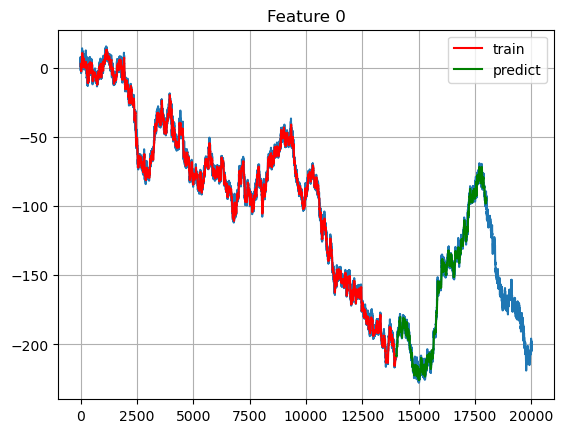

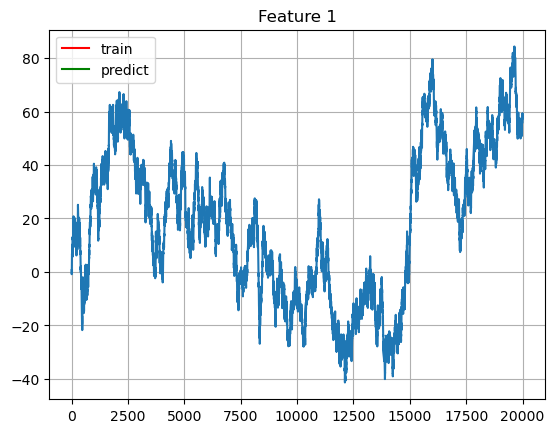

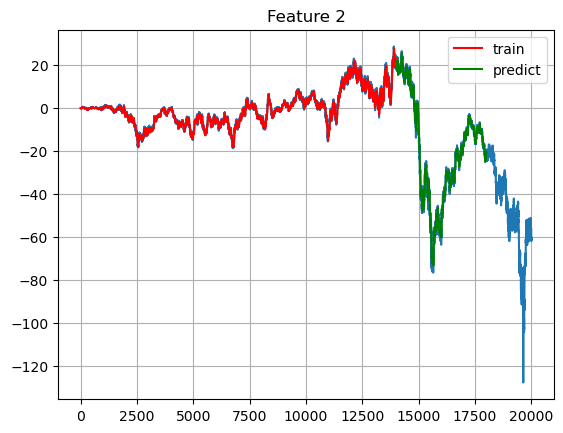

In [12]:
with torch.no_grad():
    
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback:train_size,pred_features] = tsmod(X_train).cpu()
    train_plot = scaler.inverse_transform(train_plot)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:(train_size+test_size),pred_features] = tsmod(X_test).cpu()
    test_plot = scaler.inverse_transform(test_plot)
# plot
for i in range(n_features):
    plt.plot(timeseries[:,i])
    plt.plot(train_plot[:,i], c='r', label='train')
    plt.plot(test_plot[:,i], c='g', label='predict')
    plt.title("Feature {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
with torch.no_grad():
    input = X_vld.cpu().numpy()
    output = tsmod(X_vld).cpu().numpy()
    target = y_vld.cpu().numpy()

input.shape, output.shape, target.shape

((1990, 10, 3), (1990, 2), (1990, 2))

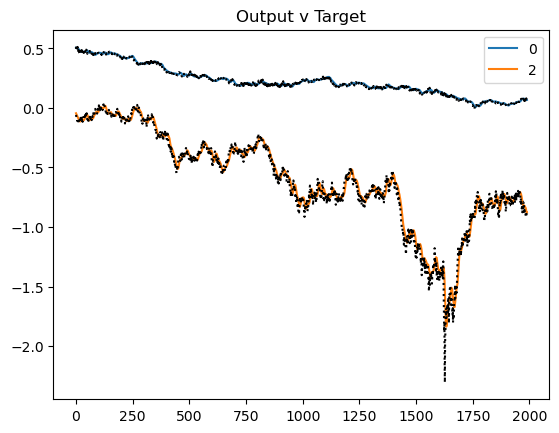

In [14]:
for d in range(n_dim):
    plt.plot(output[:,d], label=pred_features[d])
    plt.plot(target[:,d], 'k:')
    plt.legend()
plt.title("Output v Target")
plt.show()

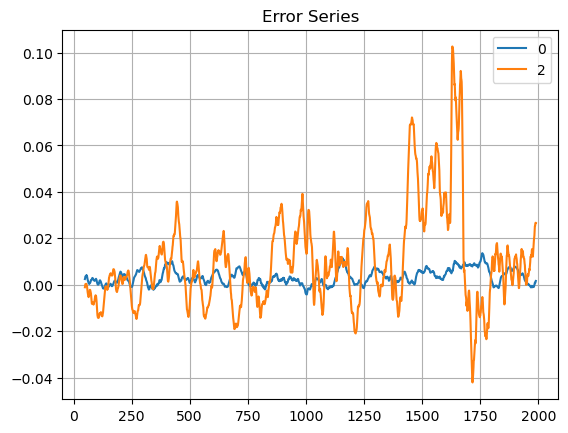

In [15]:
diff = pd.DataFrame(output - target, columns=pred_features)
diff.rolling(window=50).mean().plot(grid=True, title='Error Series');

In [16]:
print("RMSE by Series")
print(np.sqrt(np.mean(diff**2,0)))

RMSE by Series
0    0.010497
2    0.056407
dtype: float32
